In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

In [11]:
from einops import rearrange

In [59]:
import matplotlib.pyplot as plt

# Dataset

In [47]:
training_data = datasets.MNIST(root='../data/mnist/train/', train=True, download=True, transform=ToTensor())
testing_data = datasets.MNIST(root='../data/mnist/test/', train=False, download=True, transform=ToTensor())

In [64]:
img, label = training_data[0]

In [65]:
img.shape

torch.Size([1, 28, 28])

In [66]:
label

5

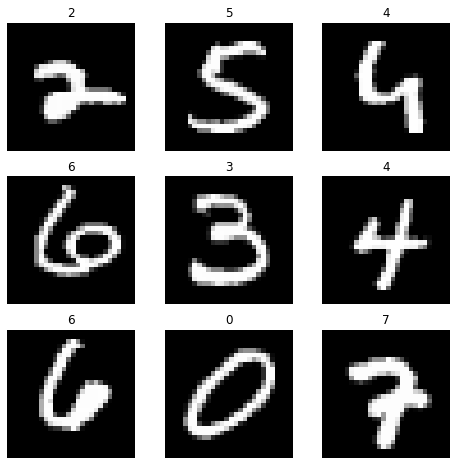

In [61]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [73]:
batch_size = 64

## Dataloader

In [48]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

# Model

In [127]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 100)
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = nn.MaxPool2d(2, 2)(x)
        x = nn.Dropout(0.1)(x)
        
        x = F.relu(self.conv2(x))
        x = nn.MaxPool2d(2, 2)(x)
        x = nn.Dropout(0.1)(x)
        
        x = rearrange(x, 'b c h d -> b (c h d)')
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim =-1)

In [91]:
x = torch.rand(23, 1, 28, 28)

In [128]:
seed = 1
epochs = 10
learning_rate = 0.001

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)

In [129]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [131]:
from tqdm import tqdm

In [132]:
def train(model):
    
    model.train()
    
    for i in range(epochs):
        for batch_idx, (img, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            img = img.to(device)
            label = label.to(device)
        
            out = model(img)
            loss = F.nll_loss(out, label) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print(f'''Train Epoch: {i+1} [{batch_idx*batch_size}/{len(training_data)}'''
              f''' ({100*batch_idx*batch_size/len(training_data):.0f}%)]\tLoss: {loss.item():.6f}''')

In [124]:
def test(model):
    
    model.eval()
    final_loss = 0
    total_correct = 0
    
    for img, label in test_dataloader:
        img = img.to(device)
        label = label.to(device)
        with torch.no_grad():
            out = model(img)
            final_loss += F.nll_loss(out, label)
            total_correct += (torch.argmax(out, dim=-1) == label).sum().item()

    print(f'''\nTest set: Average loss: {final_loss/len(test_dataloader):.4f},'''
          f''' Accuracy: {total_correct}/{len(testing_data)} ({100*total_correct/len(testing_data):.0f})%\n''')

In [133]:
train(model)

  1%|          | 5/938 [00:00<00:22, 41.03it/s]

Train Epoch: 1 [59968/60000 (100%)]	Loss: 2.119760


  0%|          | 4/938 [00:00<00:25, 36.40it/s]

Train Epoch: 2 [59968/60000 (100%)]	Loss: 1.609916


  0%|          | 4/938 [00:00<00:29, 32.12it/s]

Train Epoch: 3 [59968/60000 (100%)]	Loss: 0.909248


  0%|          | 4/938 [00:00<00:23, 39.24it/s]

Train Epoch: 4 [59968/60000 (100%)]	Loss: 0.552642


100%|██████████| 938/938 [00:25<00:00, 36.32it/s]

Train Epoch: 5 [59968/60000 (100%)]	Loss: 0.366132


In [134]:
test(model)


Test set: Average loss: 0.4793, Accuracy: 8558/10000 (86)%

